In [31]:
import numpy as np 
import matplotlib.pyplot as plt

import json
import os
import shutil
from distutils.dir_util import copy_tree
import random
import re
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models


%matplotlib inline

Copy files to the work directory so we can split them to train and validation sets:

In [32]:
def move_files(source_folder, destination_folder, files_to_move):
    # iterate files
    for file in files_to_move:
        # construct full file path
        source = source_folder + file
        destination = destination_folder + file
        # move file
        shutil.move(source, destination)

In [33]:
if not os.path.isdir('data'):
    
    # move files to work directory so we can actually move them around
    copy_tree('../input/imagerotation/', './', verbose=0)
    
    # List all image files and divide them randomly to the 2 datasets:
    files = [f for f in os.listdir('./data/images/')]
    random.shuffle(files)
    train_files = files[:30000]
    valid_files = files[30000:]
    
    # create train/valid forlders:
    os.makedirs('./data/images/train/class')
    os.makedirs('./data/images/valid/class')
    
    # populate folders:
    move_files('./data/images/', './data/images/train/class/', train_files)
    move_files('./data/images/', './data/images/valid/class/', valid_files)
    
else:
    
    train_files = [f for f in os.listdir('./data/images/train/class/')]
    valid_files = [f for f in os.listdir('./data/images/valid/class/')]

Load labels data as dictionary. The keys are the file names and the values are the labels:

In [34]:
with open('./data/label.json', 'r') as f:
    labels_list = json.load(f)
    
labels_dict = {''.join([str(key), '.jpg']): value for key, value in enumerate(labels_list)}

Define the necessary transformations for the images:

In [35]:
# required parameters for all images fed into the pretrained models:
mean_for_norm = np.array([0.485, 0.456, 0.406])
std_for_norm = np.array([0.229, 0.224, 0.225])
image_size = 224

transform = transform=transforms.Compose([transforms.Resize(image_size),
                                          transforms.RandomResizedCrop(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean_for_norm, std_for_norm),
                                          transforms.RandomErasing()])

Modify ImageFolder method to apply to regression tasks:

In [36]:
class RegressionImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, image_scores, **kwargs) -> None:
        super().__init__(root, **kwargs)
        paths, _ = zip(*self.imgs)
        file_names = [re.search(r'[\d]+.jpg',path).group() for path in paths]
        self.targets = [image_scores[file_name] for file_name in file_names]
        self.samples = self.imgs = list(zip(paths, self.targets))

Create the datasets:

In [37]:
trainset = RegressionImageFolder('./data/images/train/', labels_dict, transform=transform)
validset = RegressionImageFolder('./data/images/valid/', labels_dict, transform=transform)

Load the datases:

In [38]:
batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1)

Inspect the first few images and labels:

targets:
 [[ -3.66  19.84 -15.88 -16.79  28.14  15.46   0.32  11.68]
 [  5.94  10.59   5.6    4.57  12.16  25.12 -17.27  -2.02]
 [-17.85  23.87  -5.2    1.58  14.29  24.22  -9.98  -4.5 ]
 [  6.33 -16.56  20.49  -2.53  -3.75   9.65  -7.57 -23.82]]


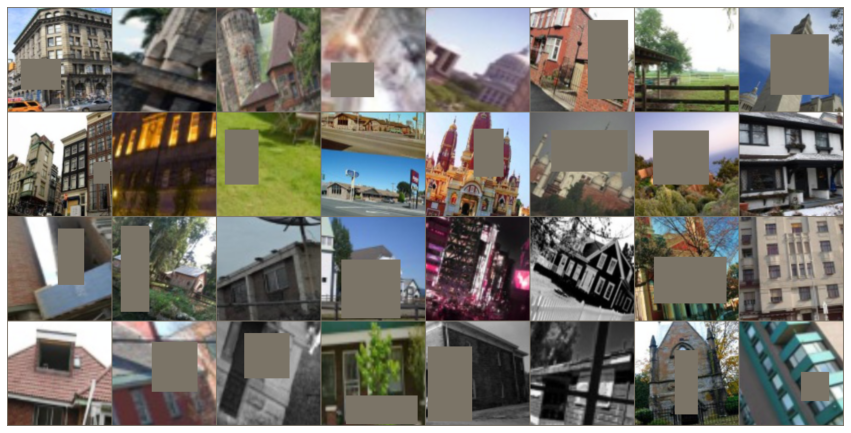

In [39]:
samples, targets = next(iter(trainloader))

grid = torchvision.utils.make_grid(samples, nrow=8) 
grid = grid.permute(1,2,0) * std_for_norm + mean_for_norm

plt.figure(figsize=(15,15))
plt.imshow(grid)
plt.axis('off')

print('targets:\n', targets.reshape(-1,8).numpy())

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Load pretrained VGG16 model for transfer learning:

In [41]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Freeze all feature extraction layers:

In [42]:
for param in model.features.parameters():
    param.requires_grad = False

Replace the output layer with a single node:

In [43]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1)

Train the model:

In [44]:
# move model to gpu if avaliable:
model.to(device=device, dtype = torch.float32)

# set hyperparameters:
epochs = 300
lr = 0.001

# define loss and optimizer:
loss_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr) 

train_rmse_log = []
val_rmse_log = []
patience = 0

for epoch in range(epochs):

    # training:
    model.train()
    total_loss = 0
    for images, labels in tqdm(trainloader, desc=f'Epoch {epoch} Training'):
        
        images = images.to(device=device, dtype = torch.float32)
        labels = labels.to(device=device, dtype = torch.float32)

        preds = model(images).squeeze()
        loss = loss_criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        
    avg_loss = total_loss/len(trainset)
    
    train_rmse = np.sqrt(avg_loss)
    train_rmse_log.append(train_rmse)

    
    # evaluation:
    model.eval()
    with torch.no_grad():

        valid_loss = 0
        for images_valid, labels_valid in tqdm(validloader, desc=f'Epoch {epoch} Evaluation'):
            
            images_valid = images_valid.to(device=device, dtype = torch.float32)
            labels_valid = labels_valid.to(device=device, dtype = torch.float32)
            
            pred_valid = model(images_valid).squeeze()
            valid_loss += loss_criterion(pred_valid, labels_valid).item() * batch_size

        avg_valid_loss = valid_loss/len(validset)
        
        val_rmse = np.sqrt(avg_valid_loss)      
        val_rmse_log.append(val_rmse)
    
    print(f"Epoch: {epoch} \ntrain RMSE: {train_rmse:2.4}, validation RMSE: {val_rmse:2.4}")
    
    # Break if overfitting occures
    if (val_rmse - train_rmse) >= 1.0:
        patience += 1
        if patience > 2:
            print("Overfitting has been detected - trainig will now stop")
            break
    else:
        patience = 0
        
    # break if the rmse plateaus:
    plateau_length = 15
    if len(train_rmse_log) >= plateau_length:
        range_last = max(train_rmse_log[-plateau_length:]) - min(train_rmse_log[-plateau_length:])
        if range_last <= 0.5:
            print("The model has reached a plateau - trainig will now stop")
            break

Epoch 0 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.21it/s]


Epoch: 0 
train RMSE: 14.38, validation RMSE: 13.08


Epoch 1 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.30it/s]


Epoch: 1 
train RMSE: 13.12, validation RMSE: 12.24


Epoch 2 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.33it/s]


Epoch: 2 
train RMSE: 12.73, validation RMSE: 11.66


Epoch 3 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.31it/s]


Epoch: 3 
train RMSE: 12.35, validation RMSE: 11.74


Epoch 4 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.34it/s]


Epoch: 4 
train RMSE: 12.13, validation RMSE: 11.39


Epoch 5 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.21it/s]


Epoch: 5 
train RMSE: 11.92, validation RMSE: 11.47


Epoch 6 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.21it/s]


Epoch: 6 
train RMSE: 11.73, validation RMSE: 11.38


Epoch 7 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.23it/s]


Epoch: 7 
train RMSE: 11.67, validation RMSE: 11.14


Epoch 8 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.34it/s]


Epoch: 8 
train RMSE: 11.59, validation RMSE: 11.15


Epoch 9 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.29it/s]


Epoch: 9 
train RMSE: 11.35, validation RMSE: 11.04


Epoch 10 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.33it/s]


Epoch: 10 
train RMSE: 11.37, validation RMSE: 10.53


Epoch 11 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.39it/s]


Epoch: 11 
train RMSE: 11.3, validation RMSE: 10.5


Epoch 12 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.31it/s]


Epoch: 12 
train RMSE: 11.15, validation RMSE: 10.35


Epoch 13 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.41it/s]


Epoch: 13 
train RMSE: 11.16, validation RMSE: 10.91


Epoch 14 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.27it/s]


Epoch: 14 
train RMSE: 11.01, validation RMSE: 10.53


Epoch 15 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.38it/s]


Epoch: 15 
train RMSE: 10.96, validation RMSE: 10.54


Epoch 16 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.26it/s]


Epoch: 16 
train RMSE: 10.89, validation RMSE: 10.6


Epoch 17 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.29it/s]


Epoch: 17 
train RMSE: 10.82, validation RMSE: 10.62


Epoch 18 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.29it/s]


Epoch: 18 
train RMSE: 10.74, validation RMSE: 10.44


Epoch 19 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.31it/s]


Epoch: 19 
train RMSE: 10.67, validation RMSE: 10.44


Epoch 20 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.31it/s]


Epoch: 20 
train RMSE: 10.77, validation RMSE: 11.26


Epoch 21 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.23it/s]


Epoch: 21 
train RMSE: 10.68, validation RMSE: 10.61


Epoch 22 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.31it/s]


Epoch: 22 
train RMSE: 10.66, validation RMSE: 10.54


Epoch 23 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.27it/s]


Epoch: 23 
train RMSE: 10.54, validation RMSE: 10.06


Epoch 24 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.18it/s]


Epoch: 24 
train RMSE: 10.62, validation RMSE: 10.7


Epoch 25 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.25it/s]


Epoch: 25 
train RMSE: 10.42, validation RMSE: 9.992


Epoch 26 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.28it/s]


Epoch: 26 
train RMSE: 10.41, validation RMSE: 10.17


Epoch 27 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.27it/s]


Epoch: 27 
train RMSE: 10.48, validation RMSE: 10.17


Epoch 28 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.22it/s]


Epoch: 28 
train RMSE: 10.29, validation RMSE: 10.64


Epoch 29 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.21it/s]


Epoch: 29 
train RMSE: 10.31, validation RMSE: 10.16


Epoch 30 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.28it/s]


Epoch: 30 
train RMSE: 10.35, validation RMSE: 10.62


Epoch 31 Evaluation: 100%|██████████| 313/313 [00:42<00:00,  7.35it/s]


Epoch: 31 
train RMSE: 10.32, validation RMSE: 10.36


Epoch 32 Evaluation: 100%|██████████| 313/313 [00:43<00:00,  7.21it/s]

Epoch: 32 
train RMSE: 10.37, validation RMSE: 10.28
The Model has reached a plateau - trainig will now stop
